In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


# Generate Synthetic IoT Dataset
 Each IoT node sends: packet_rate, energy_usage, latency, reliability
We’ll simulate 2 classes: Trustworthy (1) and Untrustworthy (0)

In [ ]:
np.random.seed(42)
num_nodes = 500
timesteps = 20
features = 4

In [ ]:
def generate_node_data(label):
    if label == 1:  # trustworthy nodes
        packet_rate = np.random.normal(80, 5, timesteps)
        energy = np.random.normal(40, 3, timesteps)
        latency = np.random.normal(30, 4, timesteps)
        reliability = np.random.normal(95, 2, timesteps)
    else:  # untrustworthy nodes
        packet_rate = np.random.normal(40, 10, timesteps)
        energy = np.random.normal(70, 8, timesteps)
        latency = np.random.normal(80, 10, timesteps)
        reliability = np.random.normal(60, 10, timesteps)
    return np.stack([packet_rate, energy, latency, reliability], axis=1)


In [ ]:
X = []
y = []
for _ in range(num_nodes):
    label = np.random.choice([0, 1])
    X.append(generate_node_data(label))
    y.append(label)


In [ ]:
X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, "Labels shape:", y.shape)

Dataset shape: (500, 20, 4) Labels shape: (500,)


#Data Augmentation (Jittering + Scaling)

In [ ]:
def augment_data(X, y):
    augmented_X = []
    augmented_y = []
    for seq, label in zip(X, y):
        # jittering
        jitter = seq + np.random.normal(0, 0.05, seq.shape)
        # scaling
        scale = seq * np.random.uniform(0.9, 1.1)
        augmented_X.append(jitter)
        augmented_X.append(scale)
        augmented_y.extend([label, label])
    return np.array(augmented_X), np.array(augmented_y)

In [ ]:
X_aug, y_aug = augment_data(X, y)
print("After augmentation:", X_aug.shape)

After augmentation: (1000, 20, 4)


In [ ]:
X_full = np.concatenate([X, X_aug])
y_full = np.concatenate([y, y_aug])


# Preprocess and Split

In [ ]:
X_full = X_full.reshape(-1, features)
scaler = MinMaxScaler()
X_full = scaler.fit_transform(X_full)
X_full = X_full.reshape(-1, timesteps, features)

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)


# LSTM Model for Trust Prediction

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(timesteps, features), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [ ]:

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7026 - loss: 0.5734 - val_accuracy: 1.0000 - val_loss: 0.0334
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 9.7816e-04
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.9362e-04
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.0588e-04 - val_accuracy: 1.0000 - val_loss: 3.2929e-04
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 4.6991e-04 - val_accuracy: 1.0000 - val_loss: 2.3708e-04
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.7234e-04 - val_accuracy: 1.0000 - val_loss: 1.7670e-04
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.8605e-04 - val_accuracy: 1.0000 - val_loss: 1.3632e-04
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 -

# Evaluate

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.3f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5827e-05 
Test Accuracy: 1.000


# Trust Score Prediction (Example)

In [ ]:
sample_node = X_test[0].reshape(1, timesteps, features)
trust_score = model.predict(sample_node)[0][0]
print(f"Predicted Trust Score: {trust_score:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Trust Score: 1.00


In [ ]:
if trust_score > 0.5:
    print("✅ Node is TRUSTWORTHY")
else:
    print("⚠️ Node is UNTRUSTWORTHY")


✅ Node is TRUSTWORTHY


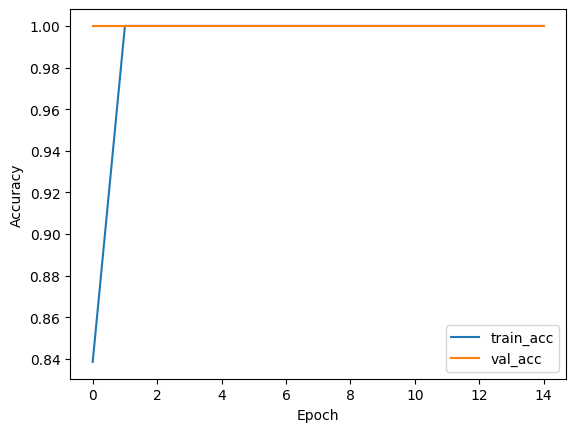

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()